In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sci
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

In [55]:
df = pd.read_csv('../dataset/numerical_data.csv') #only use with full dataset

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155361 entries, 0 to 155360
Data columns (total 37 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        155361 non-null  int64  
 1   nelements                                     155361 non-null  int64  
 2   volume                                        155361 non-null  float64
 3   density                                       155361 non-null  float64
 4   density_atomic                                155361 non-null  float64
 5   deprecated                                    155361 non-null  int64  
 6   energy_per_atom                               152149 non-null  float64
 7   formation_energy_per_atom                     152149 non-null  float64
 8   energy_above_hull                             152149 non-null  float64
 9   is_stable                                     15

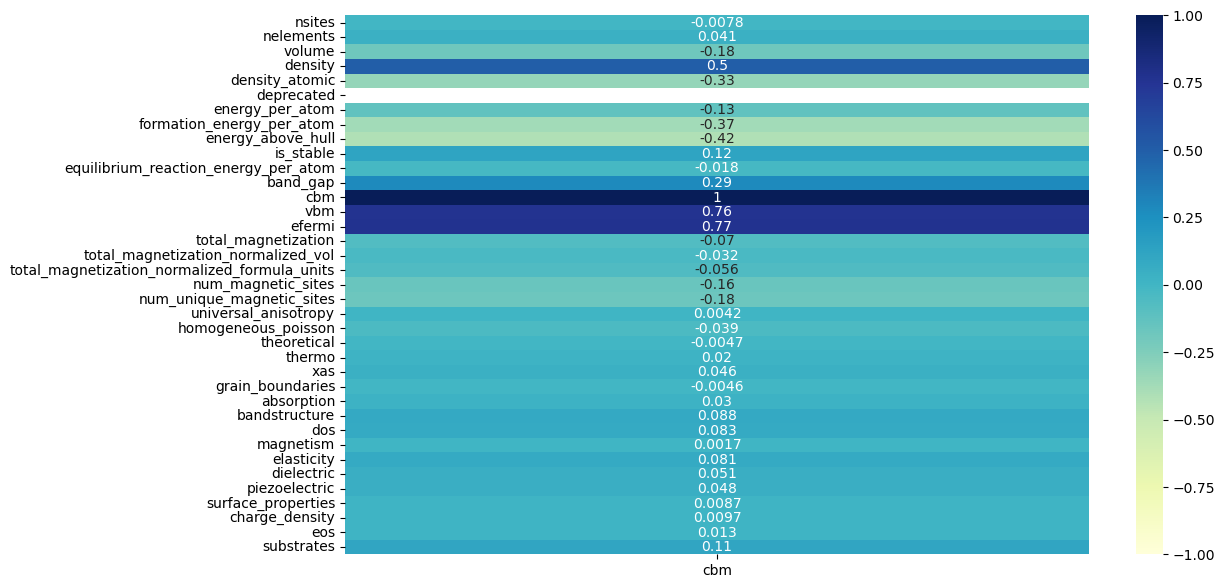

In [57]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 7))
corr_matrix = numerical_df.corr()

corr_band_gap = corr_matrix[['cbm']]
sns.heatmap(corr_band_gap, annot=True, cmap="YlGnBu", vmin=-1, vmax=1)

plt.show()

In [58]:
# Create the list of features to train with below
feature_names=['vbm','efermi','density','energy_above_hull','formation_energy_per_atom','density_atomic']

#split data into real and theoretical subsets model on real values first

numerical_df.drop(['deprecated'], axis=1, inplace=True)

real_df = numerical_df[numerical_df['theoretical'] == 0].copy()
theoretical_df = numerical_df[numerical_df['theoretical'] == 1].copy()

real_df.drop(['theoretical'], axis=1, inplace=True)
theoretical_df.drop(['theoretical'], axis=1, inplace=True)

print("Real df shape:", real_df.shape)
print("Theoretical df shape:", theoretical_df.shape)

Real df shape: (49772, 35)
Theoretical df shape: (105589, 35)


In [59]:
#Train a model for band_gap on real molecules

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor


# Select data corresponding to features in feature_names
X = real_df[feature_names]

y = real_df['cbm']

train_X, test_x, train_y, test_y = train_test_split(X, y, train_size = 0.2, random_state=1)

dtr_model = DecisionTreeRegressor(random_state=1)

dtr_model.fit(train_X, train_y)

ValueError: Input y contains NaN.

In [ ]:
predictions = dtr_model.predict(test_x)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_y, predictions)

# mean squared error (MSE) and R-squared (R2)
mse = mean_squared_error(test_y, predictions)
r2 = r2_score(test_y, predictions)

print("Mean Squared Error: ", mse)
print("R-squared: ", r2)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  0.3339946757747752
R-squared:  -0.7796969800850162
Mean Absolute Error:  0.3339946757747752
